# Velocity filter design

In [23]:
import numpy as np
from scipy import fftpack
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [24]:
file_path = "logs/COM4_2024_04_09.13.19.43.063.txt"

with open(file_path, "r") as file:
    logs = file.read()

In [25]:
# https://stackoverflow.com/questions/6999726/how-can-i-convert-a-datetime-object-to-milliseconds-since-epoch-unix-time-in-p
epoch = datetime.fromtimestamp(0)
def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1.0e3

def parse_line(line):
    timestamp_str, value_str = line.split(" -> ")
    timestamp = datetime.strptime(timestamp_str, "%H:%M:%S:%f")
    return unix_time_millis(timestamp), int(value_str)

In [26]:
lines = logs.split("\n")[1:]

times = []
values = []
deltaTimes = []
deltaValues = []
previousTime, previousValue = parse_line(lines[0])
for line in lines:
    if not "->" in line:
        continue
    time, value = parse_line(line)
    times.append(time)
    values.append(value)
    deltaTimes.append(time - previousTime)
    deltaValues.append(value - previousValue)
    previousTime, previousValue = time, value

times = np.array(times) - times[0]
values = np.array(values)
deltaTimes = np.array(deltaTimes)
deltaValues = np.array(deltaValues)

In [27]:
ranges = {
        "everything": (min(times), max(times)),
        "ramp": (10000, 20000),
        "hf_steep_drop": (44400, 45500),
        "hf_near_flat__used_for_lowpass": (44400, 44500),
        "hf_near_flat__used_for_lowpass_2": (44400, 46000),
}

window_start, window_end = ranges["hf_near_flat__used_for_lowpass_2"]
time_filter = (times >= window_start) * (times <= window_end)

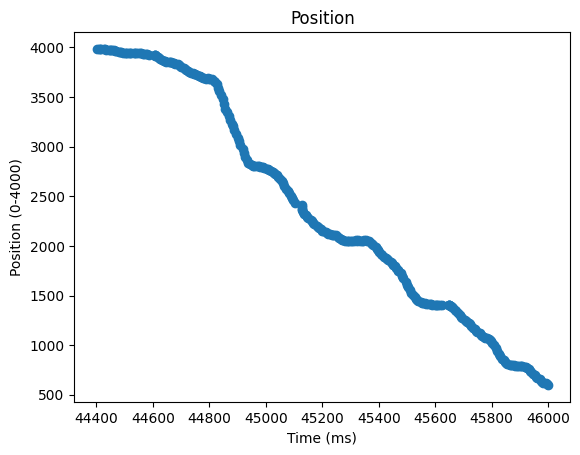

In [28]:
plt.title("Position")
plt.scatter(times[time_filter], values[time_filter])
plt.plot(times[time_filter], values[time_filter])
plt.xlabel("Time (ms)")
plt.ylabel("Position (0-4000)")
plt.show()

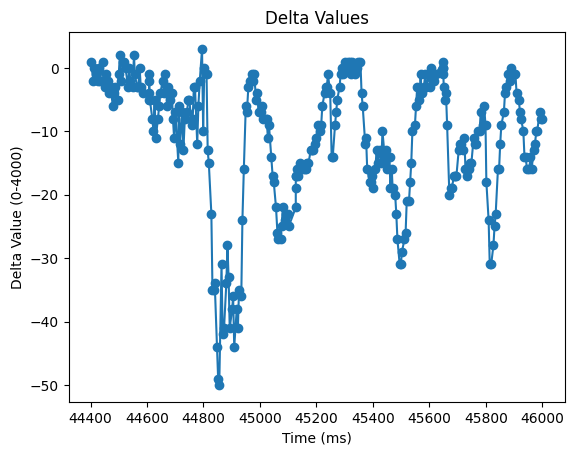

In [29]:
dvs = deltaValues[time_filter]
filter = dvs < 100
plt.title("Delta Values")
plt.scatter(times[time_filter][filter], dvs[filter])
plt.plot(times[time_filter][filter], dvs[filter])
plt.xlabel("Time (ms)")
plt.ylabel("Delta Value (0-4000)")
plt.show()

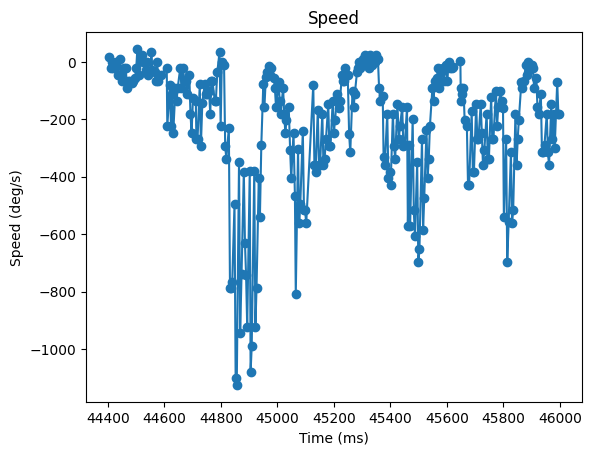

In [30]:
def div_or_default(a, b, default):
    return a/b if b != 0 else default

speeds = np.array([div_or_default(dv, dt, 0.04) for dv, dt in zip(deltaValues, deltaTimes)])
metric_speeds = speeds * (360/4000) * 1e3
filter = filter * deltaTimes[time_filter] != 0

plt.title("Speed")
plt.plot(times[time_filter][filter], metric_speeds[time_filter][filter])
plt.scatter(times[time_filter][filter], metric_speeds[time_filter][filter])
plt.xlabel("Time (ms)")
plt.ylabel("Speed (deg/s)")
plt.show()

# Generating equal time step version

Using step time = 1ms and verifying that the interpolated data properly represents the real data

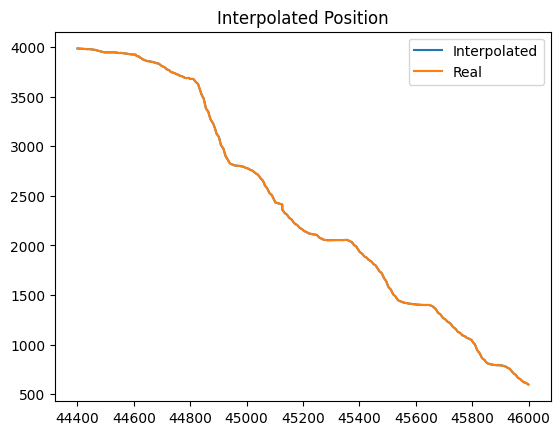

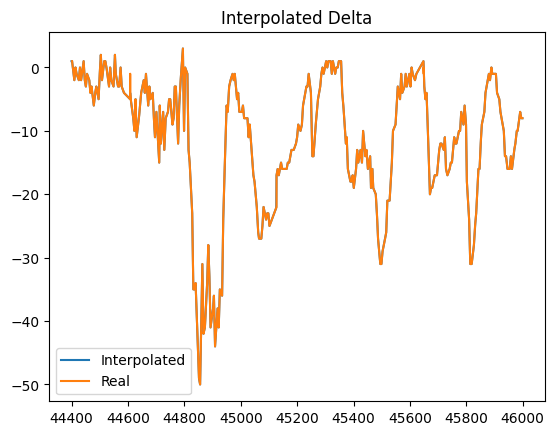

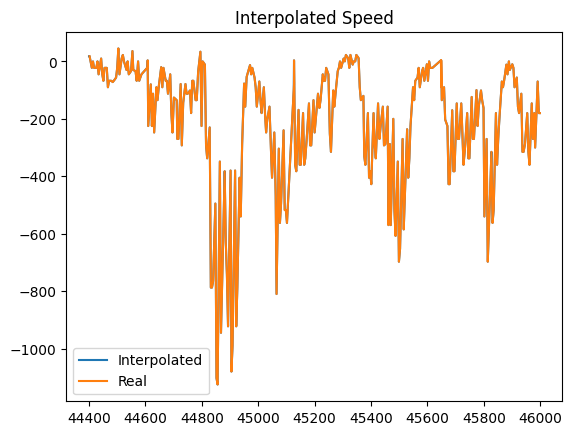

In [31]:
timeStep = 1
constantTime = np.arange(window_start, window_end, timeStep)
constantPosition = np.interp(constantTime, times[time_filter], values[time_filter])
constantDeltas = np.interp(constantTime, times[time_filter], deltaValues[time_filter])
constantSpeed = np.interp(constantTime, times[time_filter], metric_speeds[time_filter])

show_scatter = False 

def plot_compare(real, interp, title):
        plt.title(title)
        plt.plot(constantTime, interp, label="Interpolated")
        plt.plot(times[time_filter], real[time_filter], label="Real")
        if show_scatter:
                plt.scatter(constantTime, interp, label="Interpolated")
                plt.scatter(times[time_filter], real[time_filter], label="Real")
        plt.legend()
        plt.show()

plot_compare(values, constantPosition, "Interpolated Position")
plot_compare(deltaValues, constantDeltas, "Interpolated Delta")
plot_compare(metric_speeds, constantSpeed, "Interpolated Speed")

# Identifying noise using the Fast Fourier Transform

https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html

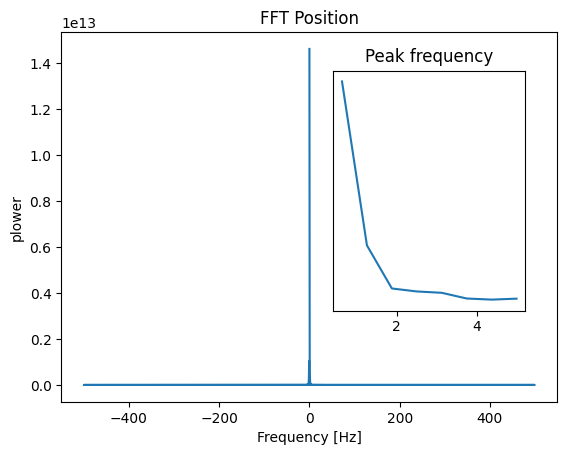

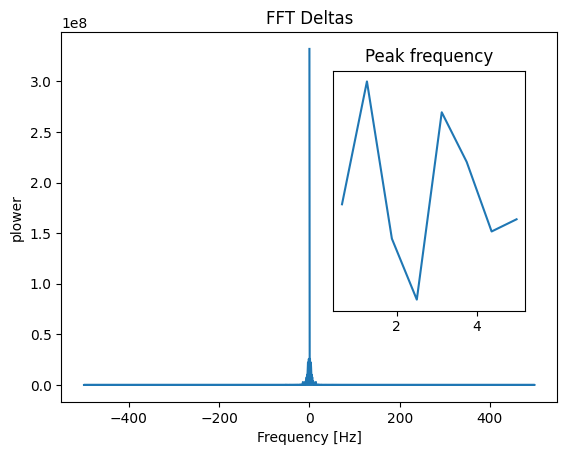

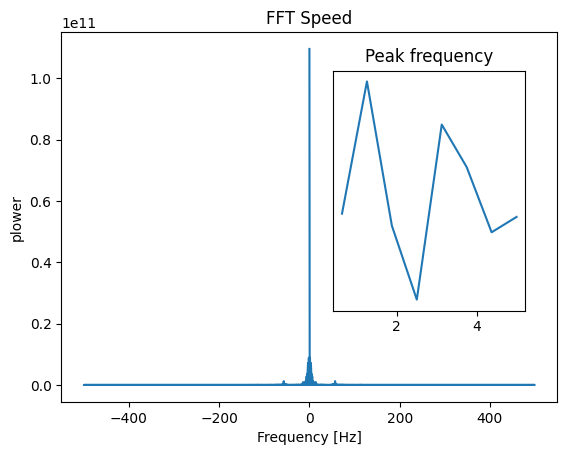

In [32]:
def fft(signal, time_step_millis, title, max_freq=np.inf):
        power = np.abs(fftpack.fft(signal))**2
        sample_freq = fftpack.fftfreq(signal.size, d=(1/1000)*time_step_millis)
        max_freq_filter = abs(sample_freq) < max_freq

        plt.title(title)
        plt.plot(sample_freq[max_freq_filter], power[max_freq_filter])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('plower')
        
        # Find the peak frequency: we can focus on only the positive frequencies
        pos_mask = np.where(sample_freq > 0)
        freqs = sample_freq[pos_mask]

        # An inner plot to show the peak frequency
        axes = plt.axes([0.55, 0.3, 0.3, 0.5])
        plt.title('Peak frequency')
        plt.plot(freqs[:8], power[pos_mask][:8])
        plt.setp(axes, yticks=[])
        
        plt.show()

max_freq = 20000
fft(constantPosition, timeStep, "FFT Position", max_freq)
fft(constantDeltas, timeStep, "FFT Deltas", max_freq)
fft(constantSpeed, timeStep, "FFT Speed", max_freq)

Looking at these graphs shows a fair estimate is that frequencies above 20Hz are not useful, making it a good cutoff frequency.

# Designing a low-pass filter

https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [33]:
# Filter requirements.
T = 1.0         # Sample Period
fs = 1000.0       # sample rate, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [34]:
def plot_filtered(cutoff):
        plt.title("Filtered position")
        plt.xlabel("Time (ms)")
        plt.ylabel("Angle (0-4000 => 0-360 deg)")
        plt.plot(constantTime, constantPosition, label="Original Position")
        plt.plot(constantTime, butter_lowpass_filter(constantPosition, cutoff), label="Filtered Position")
        plt.legend()
        plt.show()

        plt.title("Filtered delta")
        plt.xlabel("Time (ms)")
        plt.ylabel("Delta Angle (0-4000 => 0-360 deg)")
        plt.plot(constantTime, constantDeltas, label="Original Delta")
        plt.plot(constantTime, butter_lowpass_filter(constantDeltas, cutoff), label="Filtered Delta")
        plt.legend()
        plt.show()

        plt.title("Filtered speed")
        plt.xlabel("Time (ms)")
        plt.ylabel("Angular Speed deg/s")
        plt.plot(constantTime, constantSpeed, label="Original Speed")
        plt.plot(constantTime, butter_lowpass_filter(constantSpeed, cutoff), label="Filtered Speed")
        plt.legend()
        plt.show()

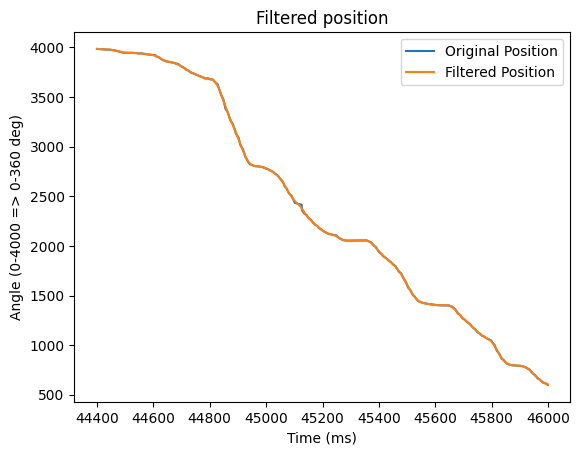

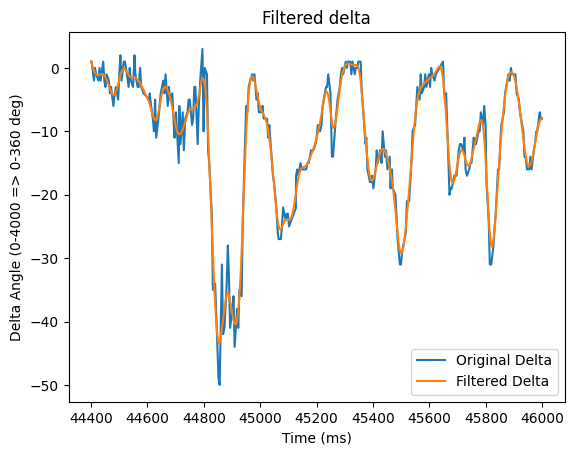

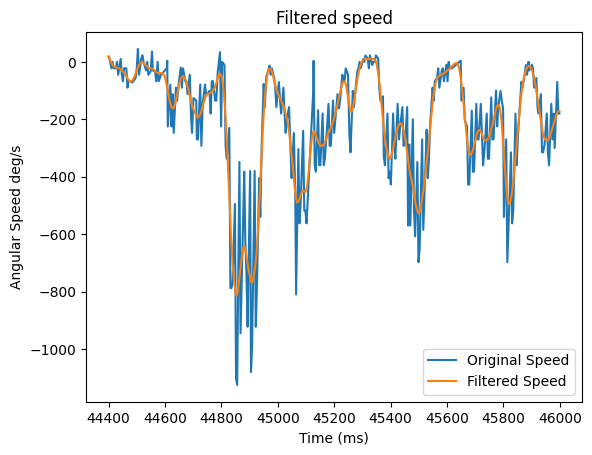

In [35]:
plot_filtered(cutoff = 20)

Using a larger window shows 20 is a bit too high. 10 seems to be a better cutoff frequency.

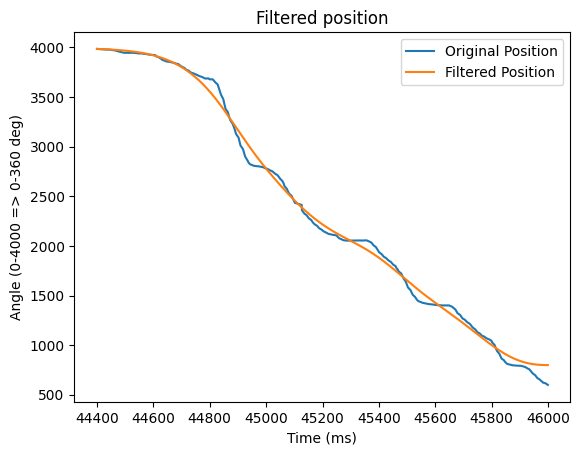

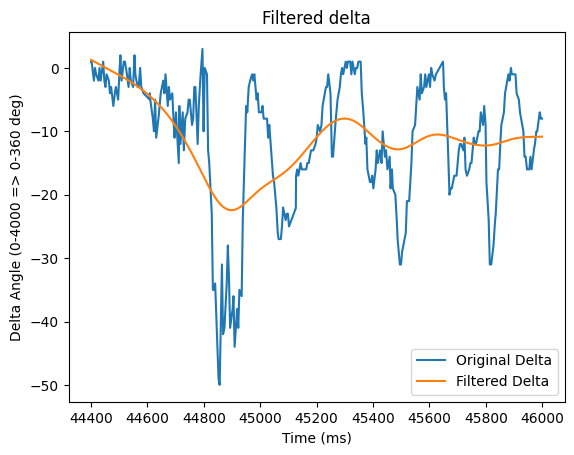

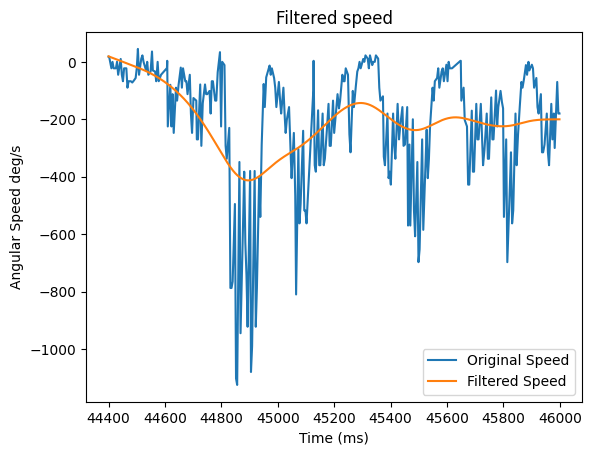

In [36]:
plot_filtered(cutoff = 2)

# Using the filtered position to generate velocity and deltas

In [37]:
def derive(times, data):
        deltas = []
        for i in range(1, len(times)):
                deltas.append((data[i] - data[i-1]) / (times[i] - times[i-1]))
        return np.array([deltas[0], *deltas])

In [38]:
filtered_times = constantTime
filtered_positions = butter_lowpass_filter(constantPosition, cutoff = 2)
filtered_speeds = derive(filtered_times, filtered_positions)

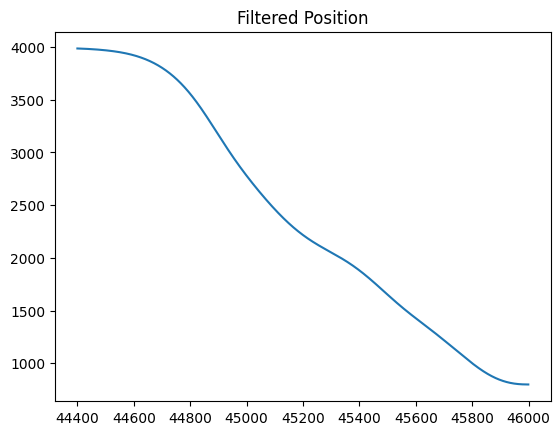

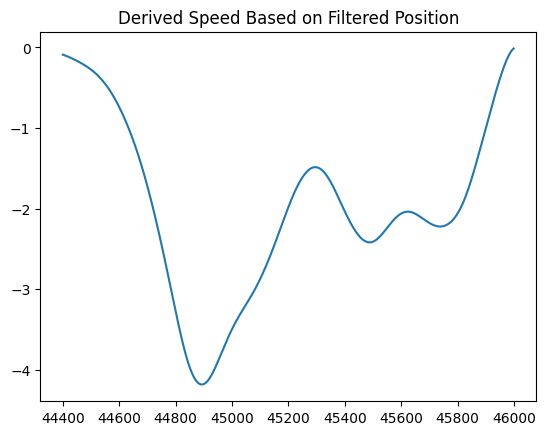

In [39]:
plt.title("Filtered Position")
plt.plot(filtered_times, filtered_positions)
plt.show()

plt.title("Derived Speed Based on Filtered Position")
plt.plot(filtered_times, filtered_speeds)
plt.show()

# Downsampling to verify the filter works at lower sampling frequencies

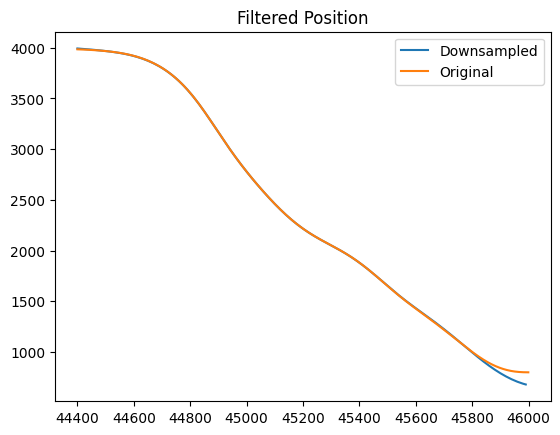

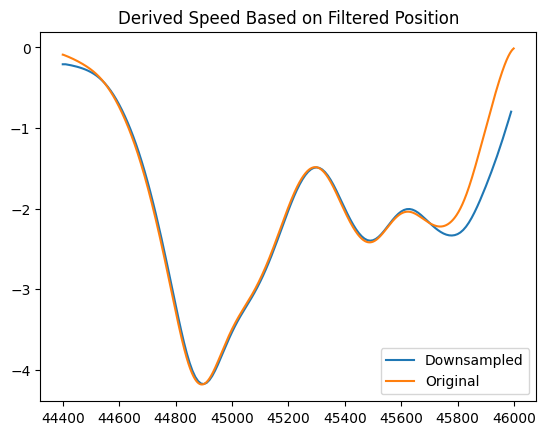

In [40]:
sample_time_ms = 10

# Filter requirements.
T = 1.0         # Sample Period
fs = 1000.0/sample_time_ms       # sample rate, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

downsampling_filter = (constantTime % sample_time_ms) == 0
downsampled_times = constantTime[downsampling_filter]
downsampled_positions = butter_lowpass_filter(constantPosition[downsampling_filter], cutoff = 2)
downsampled_speeds = derive(downsampled_times, downsampled_positions)

plt.title("Filtered Position")
plt.plot(downsampled_times, downsampled_positions, label="Downsampled")
plt.plot(filtered_times, filtered_positions, label="Original")
plt.legend()
plt.show()

plt.title("Derived Speed Based on Filtered Position")
plt.plot(downsampled_times, downsampled_speeds, label="Downsampled")
plt.plot(filtered_times, filtered_speeds, label="Original")
plt.legend()
plt.show()

Using a cutoff frequency at 2Hz seems optimal, and reducing the sample frequency does not present issues for computing velocity.

# Comparing the results to the original signal

In [41]:
def derive(times, data):
        deltas = []
        for i in range(1, len(times)):
                deltas.append((data[i] - data[i-1]) / (times[i] - times[i-1]))
        return np.array([deltas[0], *deltas])

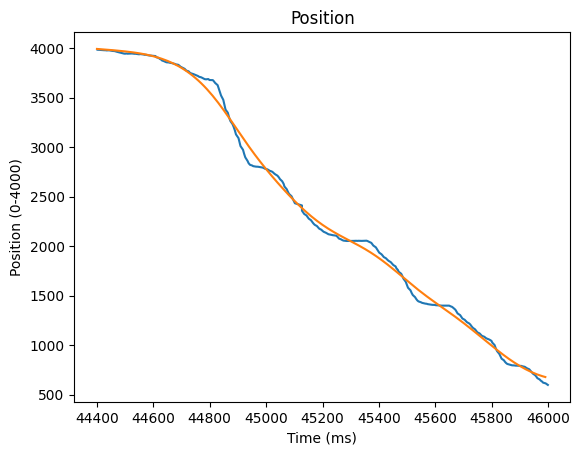

In [42]:
plt.title("Position")
plt.plot(times[time_filter], values[time_filter], label="Original")
plt.plot(downsampled_times, downsampled_positions, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Position (0-4000)")
plt.show()

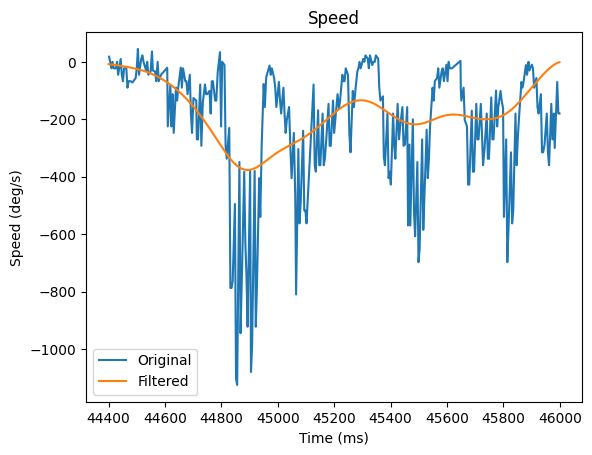

In [43]:
filtered_metric_speeds = filtered_speeds * (360/4000) * 1e3

plt.title("Speed")
plt.plot(times[time_filter][filter], metric_speeds[time_filter][filter], label="Original")
plt.plot(filtered_times, filtered_metric_speeds, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Speed (deg/s)")
plt.legend()
plt.show()

The speeds calculated from the filtered position appear to be an improved estimate of the speed.

# Calculating acceleration based on filtered speed

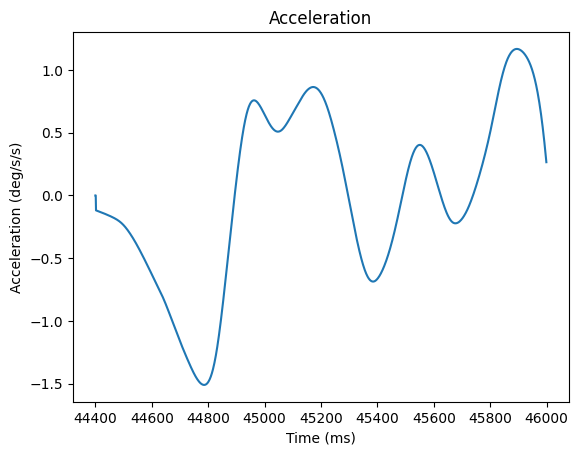

In [44]:
filtered_acceleration = derive(filtered_times, filtered_metric_speeds)

plt.title("Acceleration")
plt.plot(filtered_times, filtered_acceleration)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (deg/s/s)")
plt.show()